In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

## Sorted Spikes

In [2]:
import logging
import string
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from src.figure_utilities import (
    PAGE_HEIGHT,
    ONE_COLUMN,
    TWO_COLUMN,
    save_figure,
    set_figure_defaults,
)
from src.parameters import (
    STATE_COLORS,
    TRANSITION_TO_CATEGORY,
    STATE_ORDER,
    PROBABILITY_THRESHOLD,
)

set_figure_defaults()

In [3]:
from src.analysis import load_all_replay_info


replay_info = load_all_replay_info(
    n_unique_spiking=3,
    data_type="sorted_spikes",
    dim="1D",
    probability_threshold=PROBABILITY_THRESHOLD,
    speed_threshold=4,
    exclude_interneuron_spikes=False,
)

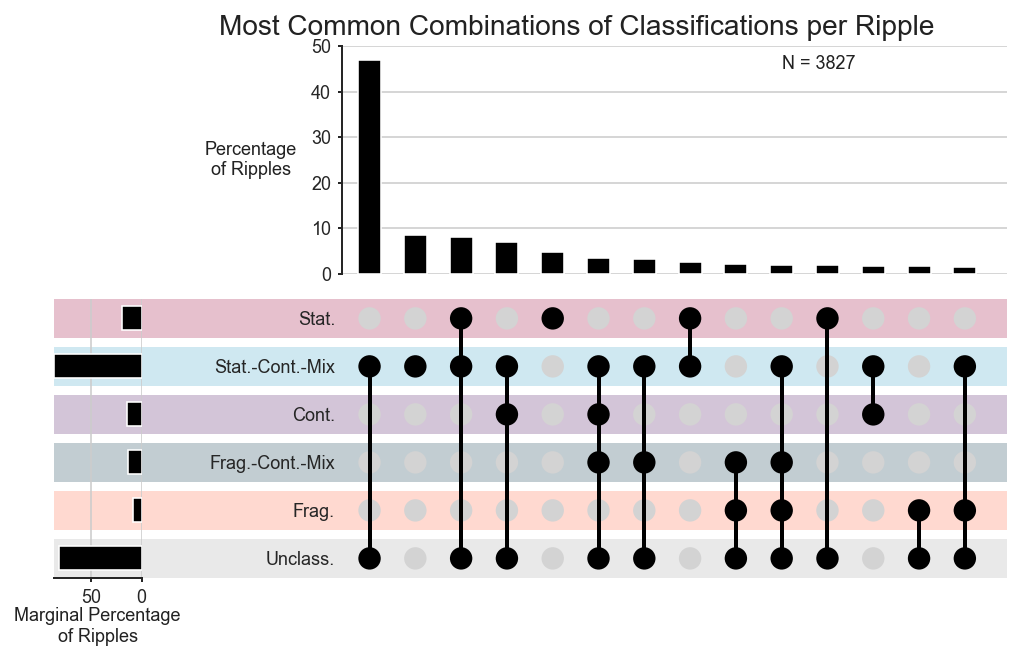

In [21]:
from src.visualization import plot_upset_classification

classified_replay_info = replay_info.loc[
    replay_info.is_classified & (replay_info.duration_classified > 0.015)
]

ax_dict, upset = plot_upset_classification(
    classified_replay_info, intersection_frac_threshold=0.01,
)

save_figure(os.path.join("Figure5-supplemental2", "figure5_upset_sorted_spikes"))

In [5]:
n_states = classified_replay_info.loc[:, STATE_ORDER[:-1]].sum(axis=1)

print(
    f"Number of single dynamic: {(n_states == 1).sum()} / {len(classified_replay_info)} or {(n_states == 1).mean() * 100:0.0f}%\n"
    f"Number of multiple dynamics: {(n_states > 1).sum()} / {len(classified_replay_info)} or {(n_states > 1).mean() * 100:0.0f}%\n"
    f"Number of >2 dynamics: {(n_states > 2).sum()} / {len(classified_replay_info)} or {(n_states > 2).mean() * 100:0.0f}%\n"
)

Number of single dynamic: 2492 / 3827 or 65%
Number of multiple dynamics: 1335 / 3827 or 35%
Number of >2 dynamics: 266 / 3827 or 7%



In [6]:
num = (classified_replay_info["Hover-Continuous-Mix"] & (n_states == 1)).sum()
denom = len(classified_replay_info)

print(
    f"Number of Only Stationary-Continuous-Mix: {num} / {denom} or {num / denom * 100:0.0f}%\n"
)

Number of Only Stationary-Continuous-Mix: 2124 / 3827 or 56%



In [7]:
is_scm = classified_replay_info["Hover-Continuous-Mix"] & (n_states == 1)
scm_duration = classified_replay_info.loc[is_scm].duration.median() * 1000
scm_distance_from_animal = classified_replay_info.loc[
    is_scm
].replay_distance_from_actual_position.median()

print(f"Only Stationary-Continuous-Mix duration: {scm_duration:0.0f} ms")
print(
    f"Only Stationary-Continuous-Mix distance from animal: {scm_distance_from_animal:0.0f} cm"
)

Only Stationary-Continuous-Mix duration: 103 ms
Only Stationary-Continuous-Mix distance from animal: 59 cm


In [8]:
is_continuous = classified_replay_info["Continuous"]
continuous_duration = classified_replay_info.loc[is_continuous].duration.median() * 1000
continuous_distance_from_animal = classified_replay_info.loc[
    is_continuous
].replay_distance_from_actual_position.median()

print(f"continuous duration: {continuous_duration:0.0f} ms")
print(f"continuous distance from animal: {continuous_distance_from_animal:0.0f} cm")

continuous duration: 124 ms
continuous distance from animal: 57 cm


In [9]:
num = (classified_replay_info["Hover"] & (n_states == 1)).sum()
denom = len(classified_replay_info)

print(f"Number of Only Stationary: {num} / {denom} or {num / denom * 100:0.0f}%\n")

Number of Only Stationary: 253 / 3827 or 7%



In [10]:
num = (classified_replay_info["Fragmented"] & (n_states == 1)).sum()
denom = len(classified_replay_info)

print(f"Number of Only Fragmented: {num} / {denom} or {num / denom * 100:0.0f}%\n")

Number of Only Fragmented: 66 / 3827 or 2%



In [11]:
has_short_duration_jump = (
    (
        classified_replay_info["Fragmented"]
        | classified_replay_info["Fragmented-Continuous-Mix"]
    )
    & (
        classified_replay_info["Hover"]
        | classified_replay_info["Hover-Continuous-Mix"]
        | classified_replay_info["Continuous"]
    )
    & (
        (classified_replay_info["Fragmented_duration"] < 0.010)
        | (classified_replay_info["Fragmented-Continuous-Mix_duration"] < 0.010)
    )
)
num = has_short_duration_jump.sum()
denom = len(classified_replay_info)

print(f"Number of short duration jump: {num} / {denom} or {num / denom * 100:0.0f}%\n")

Number of short duration jump: 485 / 3827 or 13%



In [12]:
has_spatially_coherent_and_incoherent = (
    classified_replay_info["Fragmented"]
    | classified_replay_info["Fragmented-Continuous-Mix"]
) & (
    classified_replay_info["Hover"]
    | classified_replay_info["Hover-Continuous-Mix"]
    | classified_replay_info["Continuous"]
)
num = has_spatially_coherent_and_incoherent.sum()
denom = len(classified_replay_info)

print(
    f"Number of spatially coherent and incoherent: {num} / {denom} or {num / denom * 100:0.0f}%\n"
)

Number of spatially coherent and incoherent: 495 / 3827 or 13%



In [13]:
has_no_spatially_coherent_and_incoherent = (
    classified_replay_info["Fragmented"]
    | classified_replay_info["Fragmented-Continuous-Mix"]
) & ~(
    classified_replay_info["Hover"]
    | classified_replay_info["Hover-Continuous-Mix"]
    | classified_replay_info["Continuous"]
)

num = has_no_spatially_coherent_and_incoherent.sum()
denom = len(classified_replay_info)

print(
    f"Number of not spatially coherent and incoherent: {num} / {denom} or {num / denom * 100:0.0f}%\n"
)

Number of not spatially coherent and incoherent: 169 / 3827 or 4%



In [14]:
import re
import ast


def convert_object_to_array(fixed_string):
    pattern = r"""# Match (mandatory) whitespace between...
                  (?<=\]) # ] and
                  \s+
                  (?= \[) # [, or
                  |
                  (?<=[^\[\]\s]) 
                  \s+
                  (?= [^\[\]\s]) # two non-bracket non-whitespace characters
               """

    # Replace such whitespace with a comma
    fixed_string = re.sub(pattern, ",", fixed_string, flags=re.VERBOSE)

    return np.array(ast.literal_eval(fixed_string))


def get_norm_linear_position(replay_info):
    non_local_stationary = replay_info.loc[
        replay_info.Hover_replay_distance_from_actual_position > 30
    ]
    norm_linear_position = []
    for ripple_id, df in non_local_stationary.iterrows():
        try:
            temp = (
                convert_object_to_array(df.Hover_replay_linear_position)
                / df.left_well_position
            )
            for pos in temp:
                norm_linear_position.append(pos)
        except TypeError:
            norm_linear_position.append(
                df.Hover_replay_linear_position / df.left_well_position
            )
    return np.asarray(norm_linear_position)

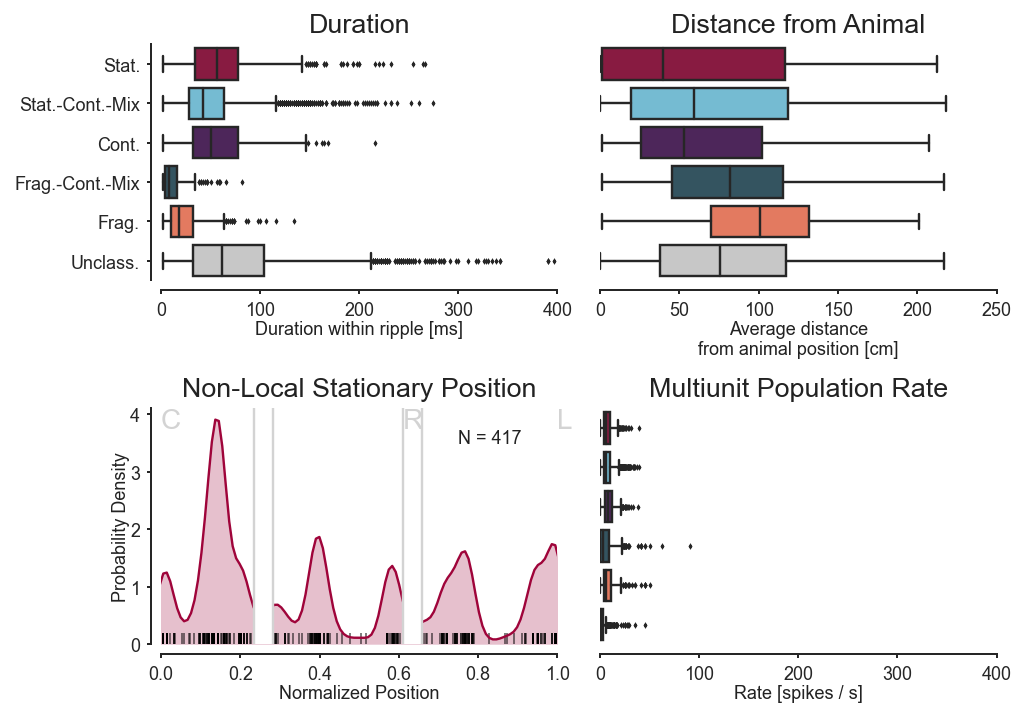

In [15]:
from src.visualization import (
    plot_replay_distance_from_actual_position,
    plot_category_duration,
    plot_linear_position_markers,
    plot_population_rate,
    _plot_category,
)
import glob

saturation, fliersize = 0.7, 1

fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(TWO_COLUMN, PAGE_HEIGHT / 2), constrained_layout=True
)

# Duration of Dynamic
plot_category_duration(
    classified_replay_info,
    kind="box",
    ax=axes[0, 0],
    fliersize=fliersize,
    saturation=saturation,
)
axes[0, 0].set_title("Duration")
axes[0, 0].set_xlim((0, 400))
sns.despine(ax=axes[0, 0], offset=5)

# Distance from Animal
plot_replay_distance_from_actual_position(
    classified_replay_info,
    kind="box",
    ax=axes[0, 1],
    fliersize=fliersize,
    saturation=saturation,
)
axes[0, 1].set_title("Distance from Animal")
sns.despine(ax=axes[0, 1], offset=5)
axes[0, 1].set_xlim((0, 250))
axes[0, 1].set_yticks([])
axes[0, 1].spines["left"].set_visible(False)

# Non-Local Stationary Position
norm_non_local_hover = get_norm_linear_position(classified_replay_info)
sns.distplot(
    norm_non_local_hover,
    kde_kws=dict(
        bw=0.020,
        clip=(0, 1),
        shade=True,
        facecolor=STATE_COLORS["Hover"],
        legend=False,
    ),
    rug_kws=dict(color="black", alpha=0.5),
    kde=True,
    rug=True,
    hist=False,
    color=STATE_COLORS["Hover"],
    ax=axes[1, 0],
)
axes[1, 0].set_xlabel("Normalized Position")
axes[1, 0].set_ylabel("Probability Density")
plot_linear_position_markers(
    classified_replay_info,
    is_normalized=True,
    jitter=0.00,
    zorder=101,
    alpha=1,
    ax=axes[1, 0],
    linestyle="-",
    fontsize=14,
)

sns.despine(ax=axes[1, 0], offset=5)
axes[1, 0].set_xlim((0, 1))
axes[1, 0].set_title("Non-Local Stationary Position")
n_non_local = norm_non_local_hover.size
axes[1, 0].text(0.75, 3.5, f"N = {n_non_local}", zorder=100, fontsize=9)

# Population firing rate
_plot_category(
    classified_replay_info,
    "population_rate",
    kind="box",
    ax=axes[1, 1],
    fliersize=fliersize,
    saturation=saturation,
)

axes[1, 1].set_xlim((0, 400))
axes[1, 1].set_xlabel("Rate [spikes / s]")
axes[1, 1].set_title("Multiunit Population Rate")
sns.despine(ax=axes[1, 1], offset=5)
axes[1, 1].set_yticks([])
axes[1, 1].spines["left"].set_visible(False)

# save_figure(os.path.join("Figure5", "figure5_dynamics_summary"))

In [16]:
from scipy.stats import ranksums

ranksums(
    classified_replay_info.Hover_population_rate,
    classified_replay_info.Continuous_population_rate,
)

RanksumsResult(statistic=41.619184337396135, pvalue=0.0)

In [17]:
np.nanmedian(classified_replay_info.Hover_population_rate), np.nanmedian(
    classified_replay_info.Continuous_population_rate
)

(6.1977122049028575, 7.857142857142858)

In [18]:
num = ((classified_replay_info.Hover_replay_distance_from_actual_position > 30)).sum()
denom = len(classified_replay_info)

print(f"Number of Non-Local Stationary: {num} / {denom} or {num / denom * 100:0.0f}%\n")

Number of Non-Local Stationary: 383 / 3827 or 10%



In [19]:
num = (
    (classified_replay_info.Hover_replay_distance_from_actual_position > 30)
    & (n_states == 1)
).sum()
denom = ((classified_replay_info.Hover_replay_distance_from_actual_position > 30)).sum()

print(f"Number of Non-Local Stationary: {num} / {denom} or {num / denom * 100:0.0f}%\n")

Number of Non-Local Stationary: 77 / 383 or 20%



In [20]:
f"{classified_replay_info.Hover_replay_distance_from_actual_position.max():0.0f}"

'212'